In [2]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
import pandas as pd
import clip
class CustomTextImageDataset(Dataset):
    def __init__(self, df, img_folder, transform=None):
        self.df = df
        self.img_folder = img_folder
        self.transform = transform
        self.tokenizer = clip.tokenize
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_folder, self.df.iloc[idx, 1])
        image = Image.open(img_name).convert("RGB")
        caption = self.df.iloc[idx, 2]

        if self.transform:
            image = self.transform(image)

        caption_indices = self.tokenizer([caption], truncate=True)[0]

        return image, caption_indices

# Example usage
df = pd.read_excel(r"C:\Users\deepak\Downloads\archive\images_info.xlsx")
img_folder = r"C:\Users\deepak\Downloads\archive\images\images"
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])
dataset = CustomTextImageDataset(df, img_folder, transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


c:\Users\deepa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\functional.py:5504: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


Epoch [1/1500], Step [1/65], Loss: 0.0929
Epoch [1/1500], Loss: 0.1014
Epoch [2/1500], Step [1/65], Loss: 0.0953
Epoch [2/1500], Loss: 0.0946
Epoch [3/1500], Step [1/65], Loss: 0.0773
Epoch [3/1500], Loss: 0.0907
Epoch [4/1500], Step [1/65], Loss: 0.0965
Epoch [4/1500], Loss: 0.0875
Epoch [5/1500], Step [1/65], Loss: 0.0904
Epoch [5/1500], Loss: 0.0851
Epoch [6/1500], Step [1/65], Loss: 0.0829
Epoch [6/1500], Loss: 0.0830
Epoch [7/1500], Step [1/65], Loss: 0.0721
Epoch [7/1500], Loss: 0.0809
Epoch [8/1500], Step [1/65], Loss: 0.0840
Epoch [8/1500], Loss: 0.0796
Epoch [9/1500], Step [1/65], Loss: 0.0814
Epoch [9/1500], Loss: 0.0787
Epoch [10/1500], Step [1/65], Loss: 0.0700
Epoch [10/1500], Loss: 0.0769
Epoch [11/1500], Step [1/65], Loss: 0.0628
Epoch [11/1500], Loss: 0.0761
Epoch [12/1500], Step [1/65], Loss: 0.0737
Epoch [12/1500], Loss: 0.0749
Epoch [13/1500], Step [1/65], Loss: 0.0643
Epoch [13/1500], Loss: 0.0738
Epoch [14/1500], Step [1/65], Loss: 0.0670
Epoch [14/1500], Loss: 0.0

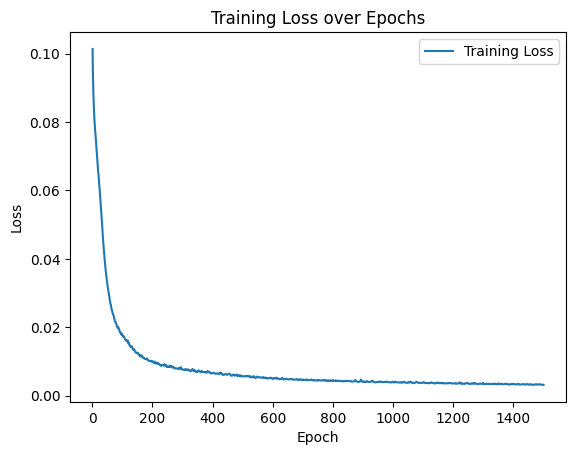

In [3]:
import requests
from PIL import Image
from io import BytesIO
import torch
import torch.nn as nn
import clip
from torchvision.utils import save_image
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim



class TextToImageModel(nn.Module):
    def __init__(self):
        super(TextToImageModel, self).__init__()
        self.clip_model, _ = clip.load("ViT-B/32", device="cuda" if torch.cuda.is_available() else "cpu")
        self.fc = nn.Linear(512, 256 * 16 * 16)  
        self.conv_layers = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),   
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),    
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),     
            nn.Sigmoid()
        )

    def forward(self, caption_indices):
        with torch.no_grad():
            text_features = self.clip_model.encode_text(caption_indices).float()  
        
        image = self.fc(text_features)
        image = image.view(-1, 256, 16, 16)  
        image = self.conv_layers(image)
        return image
    
    def generate_image(self, text, save_path='generated_image.png'):
        self.eval()
        with torch.no_grad():
            tokens = clip.tokenize([text]).to(next(self.parameters()).device)
            image = self.forward(tokens)[0]
            save_image(image, save_path)
            print(f'Image saved to {save_path}')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TextToImageModel().to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 1500
epoch_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (images, captions) in enumerate(dataloader):
        images, captions = images.to(device), captions.to(device)
        optimizer.zero_grad()
        
        outputs = model(captions)
        
        outputs = outputs[:, :, :256, :256]
        
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if i % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(dataloader)}], Loss: {loss.item():.4f}')
    
    epoch_loss = running_loss / len(dataloader)
    epoch_losses.append(epoch_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

torch.save(model.state_dict(), 'text_to_image_model.pth')
print('Model saved as text_to_image_model.pth')

plt.plot(range(1, num_epochs + 1), epoch_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.savefig('training_loss.png')
plt.show()



In [16]:
def load_model(path):
    model = TextToImageModel().to(device)
    model.load_state_dict(torch.load(path, map_location=device))
    model.eval()
    return model

loaded_model = load_model('text_to_image_model.pth')
loaded_model.generate_image("Young person looking happy", save_path='generated_image.png')


Image saved to generated_image.png
